# Model Finetuning

Fine tuning an existing vision model using the precipication data.

This notebook is largely adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os
import random
#from torchvision.models import vit_b_32, vit_h_14, vit_l_32, ViT_L_32_Weights, ViT_B_32_Weights, ViT_H_14_Weights, vit_l_16, ViT_L_16_Weights
import yaml

# Reload imported modules
# https://stackoverflow.com/a/64166391
%load_ext autoreload
%autoreload 2

# Reading config yaml

In [141]:
#torch.optim.lr_scheduler.LinearLR??

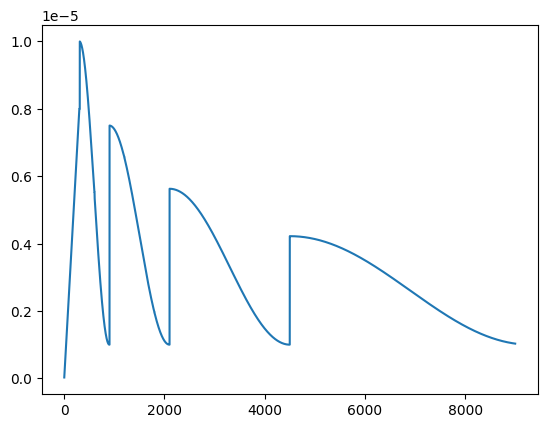

In [157]:


def initilize_CosineAnnealingWarmRestarts(optimizer,scheduler,warmup_scheduler,T_0=1, T_mult=2, eta_min=0.000001,
                                          last_epoch=-1,multiplier = 0.75,warmup_end_factor=1.0, 
                                            warmup_total_iters=300
                                         
                                         
                                         ):
    
    class CosineAnnealingWarmRestarts_2(scheduler):
        def __init__(self,optimizer,T_0=1, T_mult=2, eta_min=0.000001,last_epoch=-1,multiplier = 0.75,
                    warmup_end_factor=1.0, 
                    warmup_total_iters=300
                    
                    ):
            super().__init__(optimizer,
                        T_0 = T_0, 
                        T_mult = T_mult, 
                        eta_min = eta_min,
                        last_epoch = last_epoch)
            self.multiplier = multiplier
            
            #self.base_lrs[0] = base_lrs
    
            self.warmup = warmup_scheduler(
                        optimizer,
                        start_factor=eta_min,
                        end_factor=warmup_end_factor ,
                        total_iters=warmup_total_iters,
                    )
            
            
            
        
        def step(self,epoch=20,iteration=1,Batch_count=300):
    
            super().step(epoch + iteration / Batch_count)

            if (iteration == Batch_count-1)and (epoch+1 + self.T_0) % self.T_i ==0 :
                #print('decrease')

                self.base_lrs[0] = self.base_lrs[0] * self.multiplier
            
        def warmup_step(self):
            self.warmup.step()
    
    
    train_scheduler = CosineAnnealingWarmRestarts_2(optimizer,
                                T_0 = T_0, 
                                T_mult = T_mult, 
                                eta_min = eta_min,
                                last_epoch = last_epoch,multiplier = multiplier,
                                                   
                               warmup_end_factor = warmup_end_factor,
                                warmup_total_iters = warmup_total_iters
                                                   
                                                   )

    return train_scheduler



model = torch.nn.Linear(2, 1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.00001)

scheduler = initilize_CosineAnnealingWarmRestarts(optimizer,CosineAnnealingWarmRestarts,torch.optim.lr_scheduler.LinearLR)




lrs = []
luru = []
for i in range(30):
    for j in range(300):
        
        if j*i >= warmup.total_iters:
            scheduler.step(epoch=i,iteration=j,Batch_count=300)        
        elif j*i < warmup.total_iters:
            scheduler.warmup_step()        

        #scheduler.step(i + j / 100)
        lrs.append(
            optimizer.param_groups[0]["lr"]
        )

        
        luru.append(scheduler.T_i)
        
plt.plot(lrs)

In [2]:
from copy import deepcopy


## setting few initial params
def set_init_params(Base_configurations):
    global USE_SUBSET
    global EXCLUDE
    global SUBSET_SIZE
    global DATA_DIR
    global sub_folders
    global batch_size
    global NUM_EPOCHS
    global dropout
    global epoch_start
    
    USE_SUBSET = Base_configurations['Load_data_config']['USE_SUBSET']
    EXCLUDE = Base_configurations['Load_data_config']['EXCLUDE']
    # The number of images to take from each class for the dataset
    SUBSET_SIZE = Base_configurations['Load_data_config']['SUBSET_SIZE']
    # Expected directory path to image datasets
    DATA_DIR = Base_configurations['Load_data_config']['DATA_DIR']
    sub_folders = Base_configurations['Load_data_config']['sub_folders']

    # Hyperparameters to change 
    batch_size = Base_configurations['hparams']['batch_size']
    NUM_EPOCHS = Base_configurations['hparams']['NUM_EPOCHS']
    dropout = Base_configurations['hparams']['dropout']
    epoch_start = Base_configurations['hparams']['epoch_start']


def init_base_config(loc= 'utils/Base_configurations.yaml',set_global = True):
    if set_global:
        global Base_configurations_raw
        
        
        
    with open(loc, 'r') as file:
        Base_configurations_raw = yaml.safe_load(file)
        #display(Base_configurations_raw)
        
    if set_global:   
        set_init_params(Base_configurations_raw)
        
    return Base_configurations_raw



def load_experiment_config(Base_configurations_raw,loc = 'utils/Experiments.yaml',experiment_name = '' ,set_global = True):

    if set_global:
        global Base_configurations    
    
    Base_configurations = deepcopy(Base_configurations_raw)

    #reading experiment_config:
    with open(loc, 'r') as file:
        Experiments_configurations = yaml.safe_load(file)

    experiment_name = experiment_name if experiment_name in Experiments_configurations.keys() else Experiments_configurations['experiment_name']
    
    #updating experiment configurations
    if Experiments_configurations['Run_experiment']:
        experiment = Experiments_configurations[experiment_name]
        Base_configurations.update(**experiment)
        #display(Base_configurations)
        
    if set_global:   
        set_init_params(Base_configurations)
    
    return Base_configurations  


################# INIT #################
Base_configurations_raw = init_base_config()
Base_configurations = load_experiment_config(Base_configurations_raw,loc = 'utils/Experiments.yaml',experiment_name = '')

#set_init_params(Base_configurations)

display(Base_configurations)

{'Load_data_config': {'USE_SUBSET': True,
  'EXCLUDE': False,
  'SUBSET_SIZE': 300,
  'DATA_DIR': '../multus_data',
  'transforms_Resize': 256,
  'transforms_CenterCrop': 224,
  'transforms_Normalize': {0: [0.485, 0.456, 0.406], 1: [0.229, 0.224, 0.225]},
  'sub_folders': ['Apr2023Precipitation', 'Precip_Primary_Bovine_Satellite'],
  'parent_dir_to_exclude': 'Apr2023Precipitation',
  'class_to_exclude': '0.0'},
 'hparams': {'batch_size': 4,
  'NUM_EPOCHS': 5,
  'dropout': 0.0,
  'epoch_start': 0},
 'optimizer': {'params': {'lr': 0.002, 'momentum': 0.0}, 'name': 'SGD'},
 'scheduler': {'params': {'T_0': 1,
   'T_mult': 2,
   'eta_min': 1e-06,
   'last_epoch': -1,
   'multiplier': 0.75,
   'warmup_end_factor': 1.0,
   'warmup_total_iters': 500},
  'name': 'lr_scheduler',
  'function_name': 'CosineAnnealingWarmRestarts'},
 'timm': {'model_name': 'timm/vit_base_patch8_224.augreg2_in21k_ft_in1k',
  'pretrained': True,
  'num_classes': 5},
 'MHSA_only': False,
 'Weight_decay_only': False,
 'W

# Load Data functions

In [3]:
from utils.data_utils import subset_imagefolder, exclude_dir


## Creating data transformers

def data_transforms_func(Base_configurations,sub_folders):

    data_transforms = { i : transforms.Compose(
                                [
                                    transforms.Resize(Base_configurations['Load_data_config']['transforms_CenterCrop']),
                                    transforms.CenterCrop(Base_configurations['Load_data_config']['transforms_CenterCrop']),
                                    transforms.ToTensor(),
                                    # Rationale for Normalization https://stackoverflow.com/a/58151903
                                    transforms.Normalize(Base_configurations['Load_data_config']['transforms_Normalize'][0],

                                                        Base_configurations['Load_data_config']['transforms_Normalize'][1]

                                                        ),
                                ]
                            )

                            for i in sub_folders}
    
    return data_transforms


#creating image datasets


def create_imagedatasets(sub_folders,data_transforms,DATA_DIR=DATA_DIR,seed = 1000):


    random.seed(seed)



    # Should only a subset of data be included in dataset?
    # Useful if just trying to test the notebook locally


    image_datasets = {
        x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms[x])
        for x in sub_folders
    }

    class_names = image_datasets[sub_folders[0]].classes
    
    return image_datasets, class_names


def create_merge_dataset(image_datasets,sub_folders,Base_configurations=Base_configurations,
                         SUBSET_SIZE=SUBSET_SIZE,USE_SUBSET=USE_SUBSET,EXCLUDE=EXCLUDE): 

    if USE_SUBSET:
        image_datasets = {
            x: subset_imagefolder(image_datasets[x], subset_size=SUBSET_SIZE)
            for x in sub_folders
        }
    elif EXCLUDE:
        parent_dir_to_exclude = Base_configurations['Load_data_config']['parent_dir_to_exclude']
        class_to_exclude = Base_configurations['Load_data_config']['class_to_exclude']
        #image_datasets = {}
        for x in sub_folders:
            if x == parent_dir_to_exclude:
                image_datasets[x] = exclude_dir(image_datasets[x], class_to_exclude, SUBSET_SIZE)
            #else:
            #    image_datasets[x] = 
    merged_dataset = torch.utils.data.ConcatDataset(image_datasets.values())

    return merged_dataset
    
#******************************************************    
## Creating test val split  *******************************************

def create_test_val_split(merged_dataset,train_ratio=0.8,batch_size=batch_size,
                         shuffle=True,num_workers=0):
    train_size = int(train_ratio * len(merged_dataset))
    val_size = len(merged_dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        merged_dataset, [train_size, val_size]
    )
    datasets_for_training = {"train": train_dataset, "val": val_dataset}

    dataloaders = {
        x: torch.utils.data.DataLoader(
            datasets_for_training[x], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers
        )
        for x in ["train", "val"]
    }
    dataset_sizes = {x: len(datasets_for_training[x]) for x in ["train", "val"]}

    #setting device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    
    inputs, _ = next(iter(dataloaders["train"]))
    
    
    return dataloaders,dataset_sizes,device,inputs    
    

# model functions

In [4]:
import timm

from utils.config_utils import *

from utils.training_utils import train_model, create_writer

#model = timm.create_model('vit_base_patch32_224.augreg_in21k', pretrained=True, num_classes=5)
#model = timm.create_model('vit_base_patch32_clip_224.laion2b_ft_in12k_in1k', pretrained=True, num_classes=5)

def create_timm_model(Base_configurations,device):

    model_name = Base_configurations['timm']['model_name']
    pretrained = Base_configurations['timm']['pretrained']
    num_classes = Base_configurations['timm']['num_classes']

    model = timm.create_model(model_name, pretrained=pretrained, num_classes=num_classes)



    #num_classes = 5
    model = model.to(device)
    
    return model

#******************************************************  
## Training augmentation modules #******************************************************  
def run_util_config_pipeline(model,Base_configurations,MHSA=True,WD=True):

    #1.  only training attention head parameters
    if Base_configurations['MHSA_only'] and MHSA:
        model = attention_head_only_training(model)



    #2. decoupling weight decay

    if Base_configurations['Weight_decay_only'] and WD:
        param_groups = decoupled_weight_decay(weight_decay_dict=Base_configurations['Weight_decay'], model=model)
    else:
        param_groups = filter(lambda p: p.requires_grad, model.parameters())
        
        
    return model,param_groups





#******************************************************  #******************************************************  
# Functions #******************************************************  
#    - Loss
#    - Optimizer
#    - Scheduler

def create_loss_optim_scheduler(param_groups,Base_configurations):

    #loss function
    Loss_func = getattr(nn, Base_configurations['Loss']['name'])
    criterion = Loss_func(**Base_configurations['Loss']['params'])

    #optimizer function

    optim_func = getattr(optim, Base_configurations['optimizer']['name'])
    optimizer_ft = optim_func(param_groups,
                              **Base_configurations['optimizer']['params'])
    optimizer = type(optimizer_ft).__name__


    #schedular 
    scheduler = getattr(optim, Base_configurations['scheduler']['name'])
    scheduler_function = getattr(scheduler, Base_configurations['scheduler']['function_name'])

    if Base_configurations['scheduler']['function_name'] == 'CosineAnnealingWarmRestarts':
        exp_lr_scheduler = initilize_CosineAnnealingWarmRestarts(optimizer_ft,scheduler_function,torch.optim.lr_scheduler.LinearLR
                                                                 
                                                                 , **Base_configurations['scheduler']['params'] )
    else:
        exp_lr_scheduler = scheduler_function(optimizer_ft, **Base_configurations['scheduler']['params'])

        

    return criterion,optimizer,optimizer_ft,exp_lr_scheduler



#log dicts

def model_log_params(Base_configurations,
                    
                    optimizer
                    ,NUM_EPOCHS
                    ,dropout
                    ,batch_size
                    ,criterion
                    ,misc = ''

                    ):

    model_type = Base_configurations['model']['type']+misc # for logging 

    hparams = ( Base_configurations['optimizer']['params'] |{
                    "optimizer": optimizer,
                    "epochs": NUM_EPOCHS,
                    "dropout": dropout,
                    "Batch_size:": batch_size,
                   "loss_crit": criterion._get_name()})
    
    return model_type, hparams


    
    
#################################
## Loading and transforming data

def handle_data(Base_configurations,sub_folders,DATA_DIR=DATA_DIR,seed = 1000,
                SUBSET_SIZE=SUBSET_SIZE,USE_SUBSET=USE_SUBSET,EXCLUDE=EXCLUDE,train_ratio=0.8,
               batch_size=batch_size,shuffle=True,num_workers=0
               ):

    data_transforms = data_transforms_func(Base_configurations,sub_folders)


    image_datasets, class_names = create_imagedatasets(sub_folders,data_transforms,DATA_DIR=DATA_DIR,seed = seed)

    print("Classes: ", class_names)
    merged_dataset = create_merge_dataset(image_datasets,sub_folders,Base_configurations=Base_configurations,
                             SUBSET_SIZE=SUBSET_SIZE,USE_SUBSET=USE_SUBSET,EXCLUDE=EXCLUDE) 

    print('number of instances to be used are', len(merged_dataset))



    dataloaders,dataset_sizes,device,inputs =  create_test_val_split(merged_dataset,train_ratio=train_ratio,batch_size=batch_size,
                                                 shuffle=shuffle,num_workers=num_workers) 
    print(device)

    return dataloaders,dataset_sizes,device,inputs,merged_dataset, image_datasets, class_names,data_transforms




def run_model_fine_tuning(SUBSET_SIZE,model_type,hparams,model,criterion,optimizer_ft,exp_lr_scheduler,
              dataloaders,device,dataset_sizes,class_names,
                          
                          num_epochs=NUM_EPOCHS
                          ,epoch_start=0, writer = None, use_prior_writer= False, 
                          return_writer = False, misc = ''
             
             
             ):


    model_type = model_type+misc

    if use_prior_writer:
        if type(writer) == type(None):
            writer = create_writer(str(SUBSET_SIZE)+'_data_instances',model_type)
            writer.add_hparams(hparam_dict=hparams, metric_dict={})
    else:
        writer = create_writer(str(SUBSET_SIZE)+'_data_instances',model_type)
        writer.add_hparams(hparam_dict=hparams, metric_dict={})






    model,param_dict = train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        dataloaders,
        device,
        dataset_sizes,
        writer,
        model_type,
        class_names,
        num_epochs=NUM_EPOCHS,
        epoch_start=epoch_start
    )

    if return_writer:
        return model,param_dict, writer
    else:

        writer.close()
        return model,param_dict,None
    
    





# creating model for experiment

In [5]:




def set_experiment_model(Base_configurations,device,NUM_EPOCHS,dropout
                                                                ,batch_size,model=None,use_existing_model=False):


    if not use_existing_model:

        model = create_timm_model(Base_configurations,device)
    else:
        if type(model) == type(None):
            raise TypeError("model type is none")
        

    model,param_groups = run_util_config_pipeline(model,Base_configurations)



    criterion,optimizer,optimizer_ft,exp_lr_scheduler = create_loss_optim_scheduler(param_groups,Base_configurations)



    model_type, hparams = model_log_params(Base_configurations,

                                            optimizer
                                            ,NUM_EPOCHS
                                            ,dropout
                                            ,batch_size
                                            ,criterion
                                            )

    return model,param_groups, criterion,optimizer,optimizer_ft,exp_lr_scheduler, model_type, hparams





# Tune model and Log tensorboard

# Tune model and Log tensorboard

In [6]:
#use this function is running a new experiment
# for different experiemnts, just copy and paste this below code, after making changes in the experiment yaml and run it

Base_configurations_raw = init_base_config()
Base_configurations = load_experiment_config(Base_configurations_raw,loc = 'utils/Experiments.yaml',experiment_name = '')


if Base_configurations['first_run']:
        
    #running_dataloader
    (dataloaders,dataset_sizes,
     device,inputs,
     merged_dataset, image_datasets, 
     class_names,data_transforms) = handle_data(Base_configurations,sub_folders,DATA_DIR=DATA_DIR,seed = 1000,
                                        SUBSET_SIZE=SUBSET_SIZE,USE_SUBSET=USE_SUBSET,EXCLUDE=EXCLUDE,train_ratio=0.8,
                                       batch_size=batch_size,shuffle=True,num_workers=0
                                       )
    
    
    
    (model,param_groups, criterion,
     optimizer,optimizer_ft,
      exp_lr_scheduler, model_type, hparams) = set_experiment_model(Base_configurations,device,NUM_EPOCHS,dropout
                                                                    ,batch_size,model=None,use_existing_model=False)

    model,param_dict,writer =   run_model_fine_tuning(SUBSET_SIZE,model_type,hparams,model,criterion,optimizer_ft,exp_lr_scheduler,
                                  dataloaders,device,dataset_sizes,class_names,

                                  num_epochs=NUM_EPOCHS
                                  ,epoch_start=epoch_start, writer = None, use_prior_writer= False, 
                                  return_writer = True, misc = ''


                                 )  

Classes:  ['0.0', '0.25', '0.5', '0.75', '1.0']
number of instances to be used are 2826
cuda
[INFO] Created SummaryWriter, saving to: runs/2024-04-25/300_data_instances/vit_b_8_Cos_S_1_BS4_Trial_3/19-39-34...
Epoch 0/4
----------
current_LR: 0.00000000


KeyboardInterrupt: 

In [ ]:
#use this function is running a new experiment
# for different experiemnts, just copy and paste this below code, after making changes in the experiment yaml and run it

Base_configurations_raw = init_base_config()
Base_configurations = load_experiment_config(Base_configurations_raw,loc = 'utils/Experiments.yaml',experiment_name = 'Cos_S_1')


if Base_configurations['first_run']:
        
    #running_dataloader
    (dataloaders,dataset_sizes,
     device,inputs,
     merged_dataset, image_datasets, 
     class_names,data_transforms) = handle_data(Base_configurations,sub_folders,DATA_DIR=DATA_DIR,seed = 1000,
                                        SUBSET_SIZE=SUBSET_SIZE,USE_SUBSET=USE_SUBSET,EXCLUDE=EXCLUDE,train_ratio=0.8,
                                       batch_size=batch_size,shuffle=True,num_workers=0
                                       )
    
    
    
    (model,param_groups, criterion,
     optimizer,optimizer_ft,
      exp_lr_scheduler, model_type, hparams) = set_experiment_model(Base_configurations,device,NUM_EPOCHS,dropout
                                                                    ,batch_size,model=None,use_existing_model=False)

    model,param_dict,writer =   run_model_fine_tuning(SUBSET_SIZE,model_type,hparams,model,criterion,optimizer_ft,exp_lr_scheduler,
                                  dataloaders,device,dataset_sizes,class_names,

                                  num_epochs=NUM_EPOCHS
                                  ,epoch_start=epoch_start, writer = None, use_prior_writer= False, 
                                  return_writer = True, misc = ''


                                 )  

Classes:  ['0.0', '0.25', '0.5', '0.75', '1.0']
number of instances to be used are 20054
cuda
[INFO] Created SummaryWriter, saving to: runs/2024-04-25/3000_data_instances/vit_b_8_Cos_S_1_BS4/19-40-28...
Epoch 0/29
----------
current_LR: 0.00000000


train Loss: 0.9760 Acc: 0.5615
Per-class Accuracy:
0.0: 0.6568
0.25: 0.5549
0.5: 0.4575
0.75: 0.5310
1.0: 0.7106


val Loss: 1.0336 Acc: 0.5467
Per-class Accuracy:
0.0: 0.8493
0.25: 0.5852
0.5: 0.1744
0.75: 0.6418
1.0: 0.2553

Epoch 1/29
----------
current_LR: 0.00155525


train Loss: 0.7724 Acc: 0.6601
Per-class Accuracy:
0.0: 0.7548
0.25: 0.6542
0.5: 0.5542
0.75: 0.6180
1.0: 0.8547


val Loss: 0.5662 Acc: 0.7602
Per-class Accuracy:
0.0: 0.8933
0.25: 0.6567
0.5: 0.7883
0.75: 0.6129
1.0: 0.9628

Epoch 2/29
----------
current_LR: 0.00100089


train Loss: 0.4275 Acc: 0.8189
Per-class Accuracy:
0.0: 0.8883
0.25: 0.8260
0.5: 0.7431
0.75: 0.7600
1.0: 0.9739


val Loss: 0.3492 Acc: 0.8626
Per-class Accuracy:
0.0: 0.9092
0.25: 0.8654
0.5: 0.8014
0.75: 0.8387
1.0: 0.9787

Epoch 3/29
----------
current_LR: 0.00000100


train Loss: 0.4502 Acc: 0.8141
Per-class Accuracy:
0.0: 0.8859
0.25: 0.8155
0.5: 0.7381
0.75: 0.7675
1.0: 0.9540


val Loss: 0.4833 Acc: 0.7828
Per-class Accuracy:
0.0: 0.8221
0.25: 0.7888
0.5: 0.6200
0.75: 0.9168
1.0: 0.9628

Epoch 4/29
----------
current_LR: 0.00128058


train Loss: 0.4200 Acc: 0.8243
Per-class Accuracy:
0.0: 0.8918
0.25: 0.8159
0.5: 0.7530
0.75: 0.7928
1.0: 0.9727


val Loss: 0.3698 Acc: 0.8519
Per-class Accuracy:
0.0: 0.9007
0.25: 0.8416
0.5: 0.8034
0.75: 0.8234
1.0: 0.9840

Epoch 5/29
----------
current_LR: 0.00075065


train Loss: 0.2242 Acc: 0.9091
Per-class Accuracy:
0.0: 0.9485
0.25: 0.9095
0.5: 0.8692
0.75: 0.8810
1.0: 0.9863


val Loss: 0.2747 Acc: 0.8955
Per-class Accuracy:
0.0: 0.9129
0.25: 0.8782
0.5: 0.8952
0.75: 0.8761
1.0: 0.9681

Epoch 6/29
----------
current_LR: 0.00022063


train Loss: 0.0720 Acc: 0.9736
Per-class Accuracy:
0.0: 0.9867
0.25: 0.9777
0.5: 0.9622
0.75: 0.9547
1.0: 0.9963


val Loss: 0.2797 Acc: 0.9040
Per-class Accuracy:
0.0: 0.9326
0.25: 0.8859
0.5: 0.8821
0.75: 0.9015
1.0: 0.9787

Epoch 7/29
----------
current_LR: 0.00000100


train Loss: 0.3085 Acc: 0.8751
Per-class Accuracy:
0.0: 0.9215
0.25: 0.8688
0.5: 0.8309
0.75: 0.8494
1.0: 0.9714


val Loss: 0.5010 Acc: 0.8028
Per-class Accuracy:
0.0: 0.9485
0.25: 0.7802
0.5: 0.5938
0.75: 0.8778
1.0: 0.9840

Epoch 8/29
----------
current_LR: 0.00108224


train Loss: 0.2901 Acc: 0.8869
Per-class Accuracy:
0.0: 0.9291
0.25: 0.8782
0.5: 0.8507
0.75: 0.8627
1.0: 0.9752


val Loss: 0.4439 Acc: 0.8342
Per-class Accuracy:
0.0: 0.9026
0.25: 0.7385
0.5: 0.8831
0.75: 0.7776
1.0: 0.9628

Epoch 9/29
----------
current_LR: 0.00096043


train Loss: 0.2012 Acc: 0.9220
Per-class Accuracy:
0.0: 0.9492
0.25: 0.9183
0.5: 0.8890
0.75: 0.9149
1.0: 0.9851


val Loss: 0.3235 Acc: 0.8811
Per-class Accuracy:
0.0: 0.9326
0.25: 0.8373
0.5: 0.8851
0.75: 0.8455
1.0: 0.9521

Epoch 10/29
----------
current_LR: 0.00077812


train Loss: 0.1226 Acc: 0.9536
Per-class Accuracy:
0.0: 0.9701
0.25: 0.9505
0.5: 0.9351
0.75: 0.9493
1.0: 0.9913


val Loss: 0.3823 Acc: 0.8808
Per-class Accuracy:
0.0: 0.8951
0.25: 0.8254
0.5: 0.9163
0.75: 0.8812
1.0: 0.9574

Epoch 11/29
----------
current_LR: 0.00056306


train Loss: 0.0578 Acc: 0.9784
Per-class Accuracy:
0.0: 0.9894
0.25: 0.9775
0.5: 0.9674
0.75: 0.9731
1.0: 0.9963


val Loss: 0.3637 Acc: 0.9000
Per-class Accuracy:
0.0: 0.9513
0.25: 0.8322
0.5: 0.9113
0.75: 0.9032
1.0: 0.9628

Epoch 12/29
----------
current_LR: 0.00034798


train Loss: 0.0116 Acc: 0.9966
Per-class Accuracy:
0.0: 0.9958
0.25: 0.9971
0.5: 0.9961
0.75: 0.9969
1.0: 0.9988


val Loss: 0.4374 Acc: 0.9068
Per-class Accuracy:
0.0: 0.9363
0.25: 0.8816
0.5: 0.8629
0.75: 0.9542
1.0: 0.9787

Epoch 13/29
----------
current_LR: 0.00016564


train Loss: 0.0021 Acc: 0.9996
Per-class Accuracy:
0.0: 0.9995
0.25: 0.9998
0.5: 0.9995
0.75: 0.9996
1.0: 1.0000


val Loss: 0.3804 Acc: 0.9200
Per-class Accuracy:
0.0: 0.9279
0.25: 0.9063
0.5: 0.9123
0.75: 0.9253
1.0: 0.9840

Epoch 14/29
----------
current_LR: 0.00004380


train Loss: 0.0009 Acc: 0.9999
Per-class Accuracy:
0.0: 0.9998
0.25: 1.0000
0.5: 1.0000
0.75: 1.0000
1.0: 1.0000


val Loss: 0.3832 Acc: 0.9202
Per-class Accuracy:
0.0: 0.9288
0.25: 0.9063
0.5: 0.9123
0.75: 0.9253
1.0: 0.9840

Epoch 15/29
----------
current_LR: 0.00000100


train Loss: 0.0263 Acc: 0.9918
Per-class Accuracy:
0.0: 0.9951
0.25: 0.9920
0.5: 0.9893
0.75: 0.9879
1.0: 0.9975


val Loss: 0.7083 Acc: 0.8038
Per-class Accuracy:
0.0: 0.9719
0.25: 0.6465
0.5: 0.7369
0.75: 0.8693
1.0: 0.9787

Epoch 16/29
----------
current_LR: 0.00083566


train Loss: 0.1493 Acc: 0.9448
Per-class Accuracy:
0.0: 0.9644
0.25: 0.9404
0.5: 0.9257
0.75: 0.9391
1.0: 0.9801


val Loss: 0.6488 Acc: 0.8128
Per-class Accuracy:
0.0: 0.8586
0.25: 0.9216
0.5: 0.7288
0.75: 0.6061
1.0: 0.9628

Epoch 17/29
----------
current_LR: 0.00081168


train Loss: 0.1212 Acc: 0.9559
Per-class Accuracy:
0.0: 0.9720
0.25: 0.9523
0.5: 0.9388
0.75: 0.9512
1.0: 0.9913


val Loss: 0.3932 Acc: 0.8746
Per-class Accuracy:
0.0: 0.8961
0.25: 0.8007
0.5: 0.8770
0.75: 0.9559
1.0: 0.9468

Epoch 18/29
----------
current_LR: 0.00077275


train Loss: 0.0859 Acc: 0.9692
Per-class Accuracy:
0.0: 0.9777
0.25: 0.9662
0.5: 0.9601
0.75: 0.9668
1.0: 0.9950


val Loss: 0.4833 Acc: 0.8414
Per-class Accuracy:
0.0: 0.9326
0.25: 0.8015
0.5: 0.6976
0.75: 0.9525
1.0: 0.9840

Epoch 19/29
----------
current_LR: 0.00072035


train Loss: 0.0628 Acc: 0.9792
Per-class Accuracy:
0.0: 0.9843
0.25: 0.9771
0.5: 0.9739
0.75: 0.9785
1.0: 0.9925


val Loss: 0.3902 Acc: 0.8881
Per-class Accuracy:
0.0: 0.9448
0.25: 0.8390
0.5: 0.8458
0.75: 0.9253
1.0: 0.9787

Epoch 20/29
----------
current_LR: 0.00065650


train Loss: 0.0435 Acc: 0.9853
Per-class Accuracy:
0.0: 0.9921
0.25: 0.9838
0.5: 0.9792
0.75: 0.9828
1.0: 0.9963


val Loss: 0.4208 Acc: 0.8933
Per-class Accuracy:
0.0: 0.9316
0.25: 0.8825
0.5: 0.8065
0.75: 0.9626
1.0: 0.9840

Epoch 21/29
----------
current_LR: 0.00058365


train Loss: 0.0258 Acc: 0.9911
Per-class Accuracy:
0.0: 0.9963
0.25: 0.9912
0.5: 0.9854
0.75: 0.9891
1.0: 0.9988


val Loss: 0.4024 Acc: 0.9045
Per-class Accuracy:
0.0: 0.9232
0.25: 0.8893
0.5: 0.8770
0.75: 0.9270
1.0: 0.9681

Epoch 22/29
----------
current_LR: 0.00050460


train Loss: 0.0150 Acc: 0.9954
Per-class Accuracy:
0.0: 0.9978
0.25: 0.9950
0.5: 0.9922
0.75: 0.9961
1.0: 1.0000


val Loss: 0.4184 Acc: 0.9060
Per-class Accuracy:
0.0: 0.9391
0.25: 0.8663
0.5: 0.8750
0.75: 0.9542
1.0: 0.9787

Epoch 23/29
----------
current_LR: 0.00042240


train Loss: 0.0028 Acc: 0.9991
Per-class Accuracy:
0.0: 0.9995
0.25: 0.9990
0.5: 0.9984
0.75: 0.9996
1.0: 1.0000


val Loss: 0.4350 Acc: 0.9150
Per-class Accuracy:
0.0: 0.9251
0.25: 0.8756
0.5: 0.9224
0.75: 0.9406
1.0: 0.9840

Epoch 24/29
----------
current_LR: 0.00034019


train Loss: 0.0003 Acc: 1.0000
Per-class Accuracy:
0.0: 1.0000
0.25: 1.0000
0.5: 1.0000
0.75: 1.0000
1.0: 1.0000


val Loss: 0.4056 Acc: 0.9222
Per-class Accuracy:
0.0: 0.9326
0.25: 0.8969
0.5: 0.9194
0.75: 0.9389
1.0: 0.9840

Epoch 25/29
----------
current_LR: 0.00026114


train Loss: 0.0001 Acc: 1.0000
Per-class Accuracy:
0.0: 1.0000
0.25: 1.0000
0.5: 1.0000
0.75: 1.0000
1.0: 1.0000


val Loss: 0.4065 Acc: 0.9210
Per-class Accuracy:
0.0: 0.9232
0.25: 0.9012
0.5: 0.9194
0.75: 0.9389
1.0: 0.9840

Epoch 26/29
----------
current_LR: 0.00018829


train Loss: 0.0001 Acc: 1.0000
Per-class Accuracy:
0.0: 1.0000
0.25: 1.0000
0.5: 1.0000
0.75: 1.0000
1.0: 1.0000


val Loss: 0.4089 Acc: 0.9212
Per-class Accuracy:
0.0: 0.9232
0.25: 0.9029
0.5: 0.9194
0.75: 0.9372
1.0: 0.9840

Epoch 27/29
----------
current_LR: 0.00012443


train Loss: 0.0001 Acc: 1.0000
Per-class Accuracy:
0.0: 1.0000
0.25: 1.0000
0.5: 1.0000
0.75: 1.0000
1.0: 1.0000


val Loss: 0.4103 Acc: 0.9210
Per-class Accuracy:
0.0: 0.9232
0.25: 0.9020
0.5: 0.9194
0.75: 0.9372
1.0: 0.9840

Epoch 28/29
----------
current_LR: 0.00007203


train Loss: 0.0001 Acc: 1.0000
Per-class Accuracy:
0.0: 1.0000
0.25: 1.0000
0.5: 1.0000
0.75: 1.0000
1.0: 1.0000


val Loss: 0.4110 Acc: 0.9212
Per-class Accuracy:
0.0: 0.9232
0.25: 0.9020
0.5: 0.9204
0.75: 0.9372
1.0: 0.9840

Epoch 29/29
----------
current_LR: 0.00003308


train Loss: 0.0001 Acc: 1.0000
Per-class Accuracy:
0.0: 1.0000
0.25: 1.0000
0.5: 1.0000
0.75: 1.0000
1.0: 1.0000


val Loss: 0.4111 Acc: 0.9212
Per-class Accuracy:
0.0: 0.9232
0.25: 0.9020
0.5: 0.9204
0.75: 0.9372
1.0: 0.9840

Training complete in 570m 34s
Best val Acc: 0.922214


In [ ]:
param_dict

{'readings': {'train_accuracy': [tensor(0.5615, device='cuda:0', dtype=torch.float64),
   tensor(0.6601, device='cuda:0', dtype=torch.float64),
   tensor(0.8189, device='cuda:0', dtype=torch.float64),
   tensor(0.8141, device='cuda:0', dtype=torch.float64),
   tensor(0.8243, device='cuda:0', dtype=torch.float64),
   tensor(0.9091, device='cuda:0', dtype=torch.float64),
   tensor(0.9736, device='cuda:0', dtype=torch.float64),
   tensor(0.8751, device='cuda:0', dtype=torch.float64),
   tensor(0.8869, device='cuda:0', dtype=torch.float64),
   tensor(0.9220, device='cuda:0', dtype=torch.float64),
   tensor(0.9536, device='cuda:0', dtype=torch.float64),
   tensor(0.9784, device='cuda:0', dtype=torch.float64),
   tensor(0.9966, device='cuda:0', dtype=torch.float64),
   tensor(0.9996, device='cuda:0', dtype=torch.float64),
   tensor(0.9999, device='cuda:0', dtype=torch.float64),
   tensor(0.9918, device='cuda:0', dtype=torch.float64),
   tensor(0.9448, device='cuda:0', dtype=torch.float64),
 

In [ ]:
#use this function is running a new experiment
# for different experiemnts, just copy and paste this below code, after making changes in the experiment yaml and run it

Base_configurations_raw = init_base_config()
Base_configurations = load_experiment_config(Base_configurations_raw,loc = 'utils/Experiments.yaml',experiment_name = 'Cos_S_2')


if Base_configurations['first_run']:
        
    #running_dataloader
    (dataloaders,dataset_sizes,
     device,inputs,
     merged_dataset, image_datasets, 
     class_names,data_transforms) = handle_data(Base_configurations,sub_folders,DATA_DIR=DATA_DIR,seed = 1000,
                                        SUBSET_SIZE=SUBSET_SIZE,USE_SUBSET=USE_SUBSET,EXCLUDE=EXCLUDE,train_ratio=0.8,
                                       batch_size=batch_size,shuffle=True,num_workers=0
                                       )
    
    
    
    (model,param_groups, criterion,
     optimizer,optimizer_ft,
      exp_lr_scheduler, model_type, hparams) = set_experiment_model(Base_configurations,device,NUM_EPOCHS,dropout
                                                                    ,batch_size,model=None,use_existing_model=False)

    model,param_dict,writer =   run_model_fine_tuning(SUBSET_SIZE,model_type,hparams,model,criterion,optimizer_ft,exp_lr_scheduler,
                                  dataloaders,device,dataset_sizes,class_names,

                                  num_epochs=NUM_EPOCHS
                                  ,epoch_start=epoch_start, writer = None, use_prior_writer= False, 
                                  return_writer = True, misc = ''


                                 )  

Classes:  ['0.0', '0.25', '0.5', '0.75', '1.0']
number of instances to be used are 20054
cuda
[INFO] Created SummaryWriter, saving to: runs/2024-04-26/3000_data_instances/vit_b_8_Cos_S_2_BS4_M0/05-11-05...
Epoch 0/29
----------
current_LR: 0.00000000


train Loss: 1.0103 Acc: 0.5586
Per-class Accuracy:
0.0: 0.6087
0.25: 0.6221
0.5: 0.4770
0.75: 0.4615
1.0: 0.6288


val Loss: 0.6385 Acc: 0.7205
Per-class Accuracy:
0.0: 0.8612
0.25: 0.6251
0.5: 0.5793
0.75: 0.8397
1.0: 0.8517

Epoch 1/29
----------
current_LR: 0.00025069


train Loss: 0.5408 Acc: 0.7734
Per-class Accuracy:
0.0: 0.8624
0.25: 0.7596
0.5: 0.7127
0.75: 0.7058
1.0: 0.9094


val Loss: 0.3885 Acc: 0.8447
Per-class Accuracy:
0.0: 0.9359
0.25: 0.8163
0.5: 0.7934
0.75: 0.7873
1.0: 0.9617

Epoch 2/29
----------
current_LR: 0.00032764


train Loss: 0.3308 Acc: 0.8664
Per-class Accuracy:
0.0: 0.9253
0.25: 0.8608
0.5: 0.8276
0.75: 0.8065
1.0: 0.9770


val Loss: 0.2754 Acc: 0.8908
Per-class Accuracy:
0.0: 0.9262
0.25: 0.9044
0.5: 0.9063
0.75: 0.7524
1.0: 0.9856

Epoch 3/29
----------
current_LR: 0.00017344


train Loss: 0.1855 Acc: 0.9306
Per-class Accuracy:
0.0: 0.9635
0.25: 0.9335
0.5: 0.9080
0.75: 0.8882
1.0: 0.9885


val Loss: 0.2285 Acc: 0.9162
Per-class Accuracy:
0.0: 0.9573
0.25: 0.9368
0.5: 0.8435
0.75: 0.8937
1.0: 0.9904

Epoch 4/29
----------
current_LR: 0.00004867


train Loss: 0.1012 Acc: 0.9633
Per-class Accuracy:
0.0: 0.9854
0.25: 0.9670
0.5: 0.9471
0.75: 0.9370
1.0: 0.9911


val Loss: 0.1985 Acc: 0.9279
Per-class Accuracy:
0.0: 0.9583
0.25: 0.9343
0.5: 0.8935
0.75: 0.8968
1.0: 0.9904

Epoch 5/29
----------
current_LR: 0.00000100


train Loss: 0.2065 Acc: 0.9231
Per-class Accuracy:
0.0: 0.9572
0.25: 0.9206
0.5: 0.8926
0.75: 0.9013
1.0: 0.9809


val Loss: 0.3169 Acc: 0.8763
Per-class Accuracy:
0.0: 0.9650
0.25: 0.8396
0.5: 0.8754
0.75: 0.7730
1.0: 0.9665

Epoch 6/29
----------
current_LR: 0.00033930


train Loss: 0.1802 Acc: 0.9306
Per-class Accuracy:
0.0: 0.9570
0.25: 0.9292
0.5: 0.9108
0.75: 0.9017
1.0: 0.9923


val Loss: 0.2068 Acc: 0.9195
Per-class Accuracy:
0.0: 0.9272
0.25: 0.9418
0.5: 0.8573
0.75: 0.9333
1.0: 0.9904

Epoch 7/29
----------
current_LR: 0.00024581


train Loss: 0.0897 Acc: 0.9658
Per-class Accuracy:
0.0: 0.9844
0.25: 0.9677
0.5: 0.9504
0.75: 0.9485
1.0: 0.9898


val Loss: 0.1876 Acc: 0.9384
Per-class Accuracy:
0.0: 0.9641
0.25: 0.9252
0.5: 0.9574
0.75: 0.8778
1.0: 0.9856

Epoch 8/29
----------
current_LR: 0.00013024


train Loss: 0.0290 Acc: 0.9905
Per-class Accuracy:
0.0: 0.9964
0.25: 0.9922
0.5: 0.9871
0.75: 0.9810
1.0: 0.9974


val Loss: 0.1647 Acc: 0.9504
Per-class Accuracy:
0.0: 0.9660
0.25: 0.9568
0.5: 0.9265
0.75: 0.9349
1.0: 0.9904

Epoch 9/29
----------
current_LR: 0.00003673


train Loss: 0.0125 Acc: 0.9976
Per-class Accuracy:
0.0: 0.9993
0.25: 0.9981
0.5: 0.9974
0.75: 0.9937
1.0: 1.0000


val Loss: 0.1695 Acc: 0.9489
Per-class Accuracy:
0.0: 0.9650
0.25: 0.9518
0.5: 0.9255
0.75: 0.9397
1.0: 0.9856

Epoch 10/29
----------
current_LR: 0.00000100


train Loss: 0.0863 Acc: 0.9691
Per-class Accuracy:
0.0: 0.9857
0.25: 0.9679
0.5: 0.9571
0.75: 0.9556
1.0: 0.9936


val Loss: 0.2327 Acc: 0.9205
Per-class Accuracy:
0.0: 0.9340
0.25: 0.9534
0.5: 0.8403
0.75: 0.9381
1.0: 0.9713

Epoch 11/29
----------
current_LR: 0.00025450


train Loss: 0.0718 Acc: 0.9750
Per-class Accuracy:
0.0: 0.9854
0.25: 0.9751
0.5: 0.9671
0.75: 0.9643
1.0: 0.9936


val Loss: 0.1801 Acc: 0.9414
Per-class Accuracy:
0.0: 0.9728
0.25: 0.9277
0.5: 0.9159
0.75: 0.9381
1.0: 0.9904

Epoch 12/29
----------
current_LR: 0.00018445


train Loss: 0.0173 Acc: 0.9951
Per-class Accuracy:
0.0: 0.9978
0.25: 0.9962
0.5: 0.9931
0.75: 0.9905
1.0: 1.0000


val Loss: 0.1770 Acc: 0.9494
Per-class Accuracy:
0.0: 0.9612
0.25: 0.9510
0.5: 0.9404
0.75: 0.9286
1.0: 0.9856

Epoch 13/29
----------
current_LR: 0.00009784


val Loss: 0.1828 Acc: 0.9519
Per-class Accuracy:
0.0: 0.9641
0.25: 0.9576
0.5: 0.9286
0.75: 0.9444
1.0: 0.9856

Epoch 14/29
----------
current_LR: 0.00002777


train Loss: 0.0029 Acc: 0.9997
Per-class Accuracy:
0.0: 1.0000
0.25: 1.0000
0.5: 1.0000
0.75: 0.9980
1.0: 1.0000


val Loss: 0.1832 Acc: 0.9521
Per-class Accuracy:
0.0: 0.9621
0.25: 0.9576
0.5: 0.9308
0.75: 0.9460
1.0: 0.9856

Epoch 15/29
----------
current_LR: 0.00000100


train Loss: 0.0128 Acc: 0.9966
Per-class Accuracy:
0.0: 0.9988
0.25: 0.9958
0.5: 0.9956
0.75: 0.9952
1.0: 0.9987


val Loss: 0.2235 Acc: 0.9422
Per-class Accuracy:
0.0: 0.9476
0.25: 0.9534
0.5: 0.9084
0.75: 0.9460
1.0: 0.9904

Epoch 16/29
----------
current_LR: 0.00019090


train Loss: 0.0160 Acc: 0.9954
Per-class Accuracy:
0.0: 0.9993
0.25: 0.9962
0.5: 0.9918
0.75: 0.9917
1.0: 1.0000


val Loss: 0.3421 Acc: 0.9195
Per-class Accuracy:
0.0: 0.9029
0.25: 0.9127
0.5: 0.9201
0.75: 0.9349
1.0: 0.9904

Epoch 17/29
----------
current_LR: 0.00013842


train Loss: 0.0053 Acc: 0.9988
Per-class Accuracy:
0.0: 0.9998
0.25: 0.9992
0.5: 0.9982
0.75: 0.9972
1.0: 0.9987


val Loss: 0.2035 Acc: 0.9514
Per-class Accuracy:
0.0: 0.9631
0.25: 0.9551
0.5: 0.9297
0.75: 0.9444
1.0: 0.9904

Epoch 18/29
----------
current_LR: 0.00007355


train Loss: 0.0014 Acc: 0.9999
Per-class Accuracy:
0.0: 1.0000
0.25: 1.0000
0.5: 1.0000
0.75: 0.9992
1.0: 1.0000


val Loss: 0.2069 Acc: 0.9514
Per-class Accuracy:
0.0: 0.9631
0.25: 0.9534
0.5: 0.9329
0.75: 0.9429
1.0: 0.9904

Epoch 19/29
----------
current_LR: 0.00002106


train Loss: 0.0011 Acc: 0.9999
Per-class Accuracy:
0.0: 1.0000
0.25: 1.0000
0.5: 1.0000
0.75: 0.9996
1.0: 1.0000


val Loss: 0.2072 Acc: 0.9516
Per-class Accuracy:
0.0: 0.9631
0.25: 0.9543
0.5: 0.9329
0.75: 0.9429
1.0: 0.9904

Epoch 20/29
----------
current_LR: 0.00000100


train Loss: 0.0014 Acc: 0.9998
Per-class Accuracy:
0.0: 1.0000
0.25: 1.0000
0.5: 1.0000
0.75: 0.9988
1.0: 0.9987


val Loss: 0.2211 Acc: 0.9461
Per-class Accuracy:
0.0: 0.9631
0.25: 0.9501
0.5: 0.9265
0.75: 0.9254
1.0: 0.9904

Epoch 21/29
----------
current_LR: 0.00014320


train Loss: 0.0010 Acc: 0.9999
Per-class Accuracy:
0.0: 1.0000
0.25: 1.0000
0.5: 1.0000
0.75: 0.9992
1.0: 1.0000


val Loss: 0.2145 Acc: 0.9496
Per-class Accuracy:
0.0: 0.9631
0.25: 0.9501
0.5: 0.9350
0.75: 0.9349
1.0: 0.9904

Epoch 22/29
----------
current_LR: 0.00010390


train Loss: 0.0006 Acc: 0.9999
Per-class Accuracy:
0.0: 1.0000
0.25: 1.0000
0.5: 1.0000
0.75: 0.9996
1.0: 1.0000


val Loss: 0.2150 Acc: 0.9509
Per-class Accuracy:
0.0: 0.9641
0.25: 0.9526
0.5: 0.9340
0.75: 0.9381
1.0: 0.9904

Epoch 23/29
----------
current_LR: 0.00005532


train Loss: 0.0005 Acc: 1.0000
Per-class Accuracy:
0.0: 1.0000
0.25: 1.0000
0.5: 1.0000
0.75: 1.0000
1.0: 1.0000


val Loss: 0.2156 Acc: 0.9509
Per-class Accuracy:
0.0: 0.9641
0.25: 0.9526
0.5: 0.9340
0.75: 0.9381
1.0: 0.9904

Epoch 24/29
----------
current_LR: 0.00001602


train Loss: 0.0004 Acc: 1.0000
Per-class Accuracy:
0.0: 1.0000
0.25: 1.0000
0.5: 1.0000
0.75: 1.0000
1.0: 1.0000


train Loss: 0.0004 Acc: 1.0000
Per-class Accuracy:
0.0: 1.0000
0.25: 1.0000
0.5: 1.0000
0.75: 1.0000
1.0: 1.0000


val Loss: 0.2181 Acc: 0.9514
Per-class Accuracy:
0.0: 0.9641
0.25: 0.9526
0.5: 0.9372
0.75: 0.9365
1.0: 0.9904

Epoch 26/29
----------
current_LR: 0.00010742


train Loss: 0.0004 Acc: 1.0000
Per-class Accuracy:
0.0: 1.0000
0.25: 1.0000
0.5: 1.0000
0.75: 1.0000
1.0: 1.0000


val Loss: 0.2193 Acc: 0.9499
Per-class Accuracy:
0.0: 0.9631
0.25: 0.9526
0.5: 0.9329
0.75: 0.9349
1.0: 0.9904

Epoch 27/29
----------
current_LR: 0.00007801


train Loss: 0.0003 Acc: 1.0000
Per-class Accuracy:
0.0: 1.0000
0.25: 1.0000
0.5: 1.0000
0.75: 1.0000
1.0: 1.0000


val Loss: 0.2200 Acc: 0.9504
Per-class Accuracy:
0.0: 0.9641
0.25: 0.9510
0.5: 0.9350
0.75: 0.9365
1.0: 0.9904

Epoch 28/29
----------
current_LR: 0.00004166


train Loss: 0.0003 Acc: 1.0000
Per-class Accuracy:
0.0: 1.0000
0.25: 1.0000
0.5: 1.0000
0.75: 1.0000
1.0: 1.0000


val Loss: 0.2203 Acc: 0.9506
Per-class Accuracy:
0.0: 0.9641
0.25: 0.9518
0.5: 0.9350
0.75: 0.9365
1.0: 0.9904

Epoch 29/29
----------
current_LR: 0.00001224


train Loss: 0.0003 Acc: 1.0000
Per-class Accuracy:
0.0: 1.0000
0.25: 1.0000
0.5: 1.0000
0.75: 1.0000
1.0: 1.0000


val Loss: 0.2202 Acc: 0.9506
Per-class Accuracy:
0.0: 0.9641
0.25: 0.9518
0.5: 0.9350
0.75: 0.9365
1.0: 0.9904

Training complete in 570m 2s
Best val Acc: 0.952132


In [9]:
param_dict

{'readings': {'train_accuracy': [tensor(0.5586, device='cuda:0', dtype=torch.float64),
   tensor(0.7734, device='cuda:0', dtype=torch.float64),
   tensor(0.8664, device='cuda:0', dtype=torch.float64),
   tensor(0.9306, device='cuda:0', dtype=torch.float64),
   tensor(0.9633, device='cuda:0', dtype=torch.float64),
   tensor(0.9231, device='cuda:0', dtype=torch.float64),
   tensor(0.9306, device='cuda:0', dtype=torch.float64),
   tensor(0.9658, device='cuda:0', dtype=torch.float64),
   tensor(0.9905, device='cuda:0', dtype=torch.float64),
   tensor(0.9976, device='cuda:0', dtype=torch.float64),
   tensor(0.9691, device='cuda:0', dtype=torch.float64),
   tensor(0.9750, device='cuda:0', dtype=torch.float64),
   tensor(0.9951, device='cuda:0', dtype=torch.float64),
   tensor(0.9994, device='cuda:0', dtype=torch.float64),
   tensor(0.9997, device='cuda:0', dtype=torch.float64),
   tensor(0.9966, device='cuda:0', dtype=torch.float64),
   tensor(0.9954, device='cuda:0', dtype=torch.float64),
 

In [ ]:
#use this function is running an extended experiment. which uses an existing model.
# for different experiemnts, just copy and paste this below code, after making changes in the experiment yaml and run it



Base_configurations_raw = init_base_config()
Base_configurations = load_experiment_config(Base_configurations_raw,loc = 'utils/Experiments.yaml',experiment_name = '')

if not Base_configurations['first_run']:

    #running_dataloader
    (dataloaders,dataset_sizes,
     device,inputs,
     merged_dataset, image_datasets, 
     class_names,data_transforms) = handle_data(Base_configurations,sub_folders,DATA_DIR=DATA_DIR,seed = 1000,
                                        SUBSET_SIZE=SUBSET_SIZE,USE_SUBSET=USE_SUBSET,EXCLUDE=EXCLUDE,train_ratio=0.8,
                                       batch_size=batch_size,shuffle=True,num_workers=0
                                       )

    
    
    model,param_groups, criterion,optimizer,optimizer_ft,exp_lr_scheduler, model_type, hparams = set_experiment_model(Base_configurations,device,NUM_EPOCHS,dropout
                                                                    ,batch_size,model=model,use_existing_model=True)

    model,param_dict,writer =   run_model_fine_tuning(SUBSET_SIZE,model_type,hparams,model,criterion,optimizer_ft,exp_lr_scheduler,
                  dataloaders,device,dataset_sizes,class_names,

                              num_epochs=NUM_EPOCHS
                              ,epoch_start=epoch_start, writer = writer, use_prior_writer= False, 
                              return_writer = True, misc = '_ext'


                 )  

Classes:  ['0.0', '0.25', '0.5', '0.75', '1.0']
number of instances to be used are 20054
cuda
[INFO] Created SummaryWriter, saving to: runs/2024-04-24/3000_data_instances/vit_b_8_WD_6_extended_WD_0_01_0_1_LR_0_0002_ext/12-00-39...
Epoch 0/9
----------


Epoch 0, train:  35%|███▌      | 178/502 [05:16<09:37,  1.78s/it, loss=0.343] 

In [21]:
param_dict

{'readings': {'train_accuracy': [0.16603184349517724,
   0.16533689905857346,
   0.1649716500758768,
   0.16462437614667583,
   0.16441406906073708,
   0.162729467588017,
   0.16252789485537597,
   0.16248339926937175,
   0.16243544908998941,
   0.1623968340724452],
  'train_loss': [tensor(0.9438, device='cuda:0', dtype=torch.float64),
   tensor(0.9440, device='cuda:0', dtype=torch.float64),
   tensor(0.9440, device='cuda:0', dtype=torch.float64),
   tensor(0.9443, device='cuda:0', dtype=torch.float64),
   tensor(0.9438, device='cuda:0', dtype=torch.float64),
   tensor(0.9455, device='cuda:0', dtype=torch.float64),
   tensor(0.9455, device='cuda:0', dtype=torch.float64),
   tensor(0.9454, device='cuda:0', dtype=torch.float64),
   tensor(0.9455, device='cuda:0', dtype=torch.float64),
   tensor(0.9456, device='cuda:0', dtype=torch.float64)],
  'val_accuracy': [0.2548824239590019,
   0.2541029055541782,
   0.25320863921396813,
   0.2542256734883531,
   0.2542970071046824,
   0.25355152906

In [ ]:
param_dict

{'readings': {'train_accuracy': [0.9178886822146355,
   0.5675856911957,
   0.4640848559999023,
   0.4062937527183493,
   0.3713093530966042,
   0.34898006676501825,
   0.3328126991734365,
   0.3330253208393837,
   0.34516058780008185,
   0.3431067426424776,
   0.22347840374562164,
   0.20834964235037898,
   0.20148387918751384,
   0.1978761576483436,
   0.1931260202591098,
   0.19066529757570969,
   0.1867432863027357,
   0.18646502398028306,
   0.18390069078167112,
   0.18114587800491483,
   0.16753582335288245,
   0.16591849314566823,
   0.16554717149162637,
   0.16499431666147232,
   0.16448517150924752],
  'train_loss': [tensor(0.6140, device='cuda:0', dtype=torch.float64),
   tensor(0.7739, device='cuda:0', dtype=torch.float64),
   tensor(0.8139, device='cuda:0', dtype=torch.float64),
   tensor(0.8395, device='cuda:0', dtype=torch.float64),
   tensor(0.8551, device='cuda:0', dtype=torch.float64),
   tensor(0.8636, device='cuda:0', dtype=torch.float64),
   tensor(0.8700, device='c

In [43]:
from utils.training_utils import visualize_model

visualize_model(model[0], dataloaders, device, class_names, imshow, num_images=4)

NameError: name 'imshow' is not defined